In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from PIL import Image

DATA_DIR = 'data/'
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'
VALID_DIR = 'data/valid'

TEST_IMAGE = 'data/test/five of diamonds/2.jpg'

# DATASET

In [33]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data=ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes


In [34]:
dataset = PlayingCardDataset('data/train')

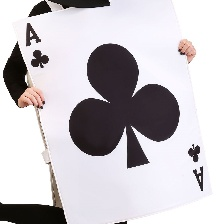

In [35]:
image, label = dataset[0]
image

In [36]:
target_to_class = {v:k for k, v in ImageFolder(TRAIN_DIR).class_to_idx.items()}
print(target_to_class)


{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [37]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = PlayingCardDataset('data/train', transform)

In [38]:
image, label = dataset[0]
print(label)
image.size()

0


torch.Size([3, 128, 128])

# DATALOADER

In [39]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [40]:
for images, labels in dataloader:
    break
images.shape, labels.shape # data has now been batched to 32

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

# PYTORCH MODEL

In [41]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_size = 1280

        self.classifier = nn.Linear(enet_out_size, num_classes)
    
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [42]:
model = SimpleCardClassifier(num_classes=53)
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [43]:
example_output = model(images)
example_output.size() # [batch_size, num_classes]

torch.Size([32, 53])

# TRAINING MODEL

In [44]:
# Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [45]:
criterion(example_output, labels)

tensor(3.9367, grad_fn=<NllLossBackward0>)

In [49]:

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()    
])

train_dataset = PlayingCardDataset(TRAIN_DIR, transform=transform)
val_dataset = PlayingCardDataset(VALID_DIR, transform=transform)
test_dataset = PlayingCardDataset(TEST_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [51]:
num_epochs = 5
train_losses, val_losses = [], []

model = SimpleCardClassifier(num_classes=53)
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader,'Training Loop'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader,'Validation Loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation Loss: {val_loss}")

Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 4.012697611625647, Validation Loss: 4.03473175066822


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 4.011993861273479, Validation Loss: 4.033091130346622


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 4.011719044208026, Validation Loss: 4.038008579218163


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 4.0154882327957395, Validation Loss: 4.046973485766717


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 4.009384591581939, Validation Loss: 4.042371937014022


# Visualize Losses

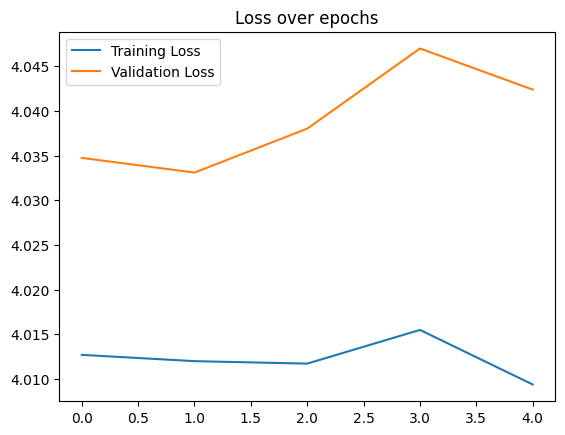

In [52]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Evaluation



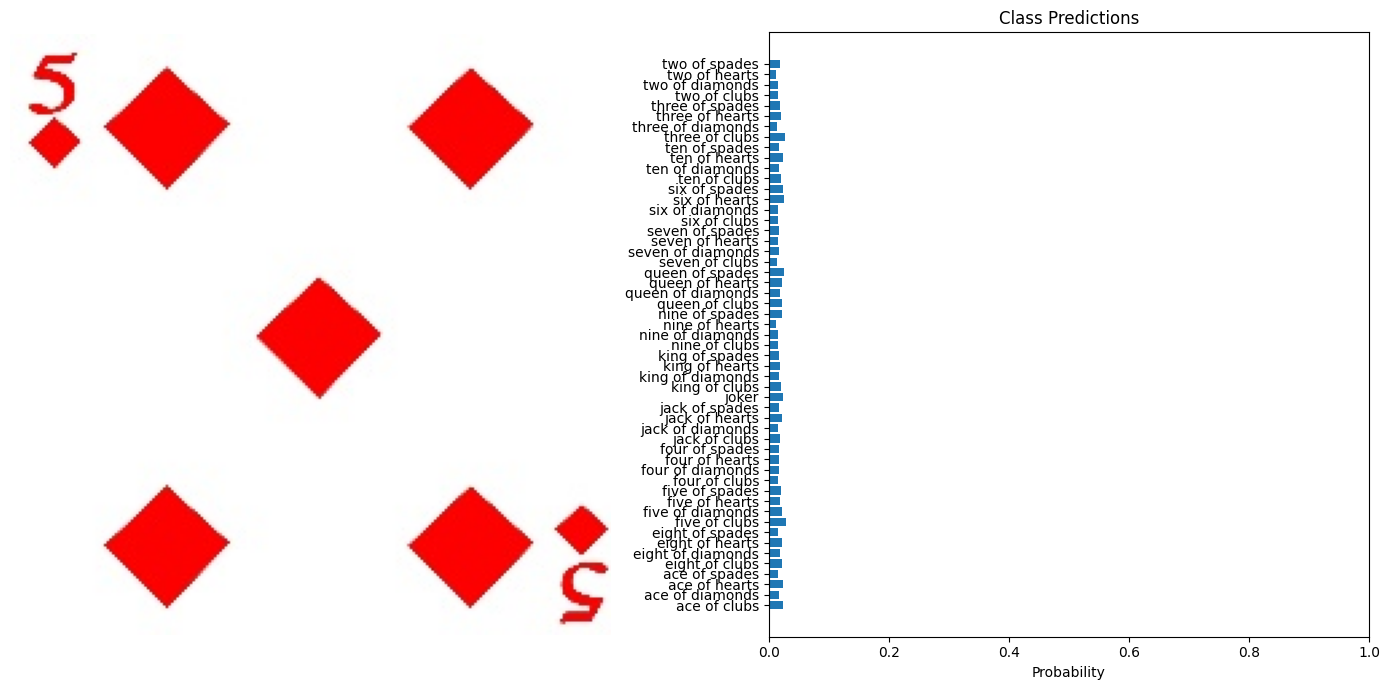

In [53]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1,2,figsize=(14,7))

    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(TEST_IMAGE, transform)
probabilities = predict(model, image_tensor, device)

class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)
